This notebook replaces all others, and is intended as the single source of truth for the de Berker et al., stroke paper.

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.colors import LogNorm
import eli5

import itertools
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget

from pprint import pprint
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

sns.set(style="ticks", color_codes=True)
#flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
#sns.set_palette(sns.color_palette(flatui))
sns.__version__

'0.9.0'

In [98]:
np.random.seed(1234)

In [99]:
full_figure_width = 18
figure_height = 8
_xlabel_size = 15
_ylabel_size = 15

In [100]:
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=int(_xlabel_size*0.8))
    plt.yticks(tick_marks, classes, fontsize=int(_xlabel_size*0.8))

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=_xlabel_size)
    plt.xlabel('Predicted label', fontsize=_ylabel_size)

## 1. Basic data analysis

In [101]:
df = pd.read_excel('../data/Discharge destinations 2.xlsx', 
                   sheet_name='Regression analysis',
                  header=2)

df.reset_index(inplace=True)
df.drop(['index', 'Key'], axis=1, inplace=True)
outcome_dict={0:'Death', 1:'Inpatient', 2:'CH', 3:'Home'}
df['Outcome']=df['Outcome'].map(lambda x: outcome_dict[x])

In [102]:
order = ['Home', 'Comm. Hosp.', 'Inpatient', 'Death']

In [103]:
df.head()

,Age,NIHSS,MRS,Outcome
0,66,22,1,Death
1,83,15,4,Death
2,83,21,2,Death
3,81,24,1,Death
4,81,21,1,Death


In [104]:
len(df)

1131

The pairplot shows all the differnet relationships in the data in one place.

Here we can see:

1. All groups are fairly similar in age, although in patient are perhaps on average slightly older and community hospital younger
2. Low NIHSS scores are associated with home or CH. Higher scores correspond to death.
3. Low MRS scores seem to be associated with Home, whilst high ones are associated with being an inpatient.

The scatter plots are a bit confusing, but it seems like MRS and age are positivel correlated. NIHSS and MRS are unclear.

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


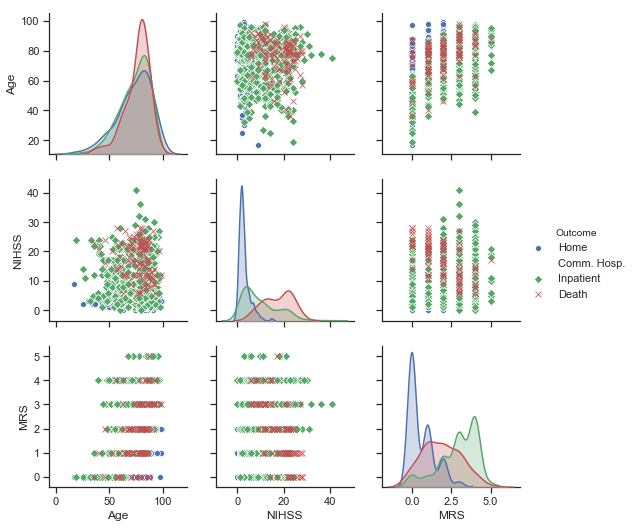

In [193]:
sns.pairplot(df, hue='Outcome', markers=["o", "s", "D", "x"], hue_order=order)

## Digging into correlations between predictors

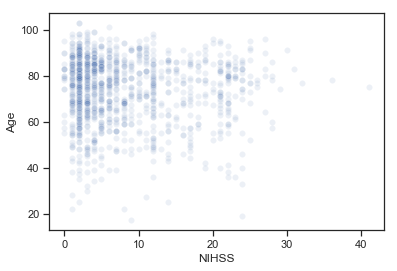

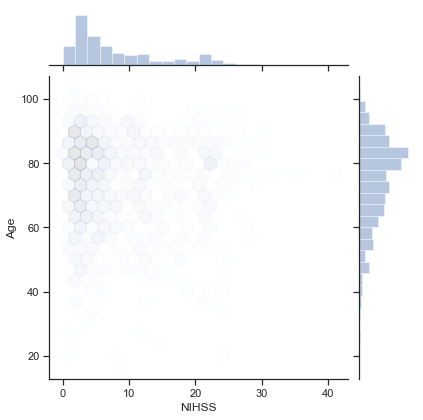

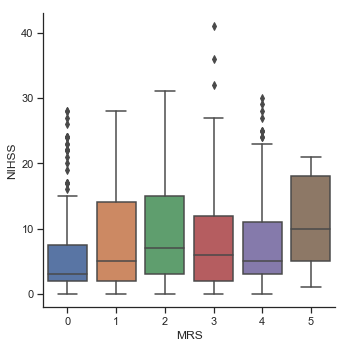

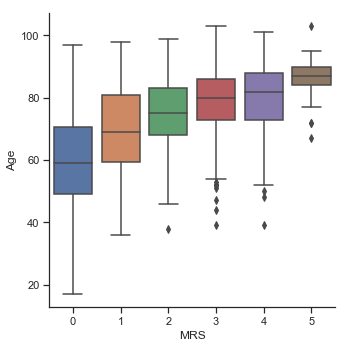

In [106]:
sns.scatterplot(x='NIHSS', y='Age', data=df, alpha=.1)
sns.jointplot(x='NIHSS', y='Age', data=df, alpha=.1, kind='hex')


sns.catplot(x="MRS", y="NIHSS", kind="box", data=df)
sns.catplot(x="MRS", y="Age", kind="box", data=df)

From this, it seems:
    
1. MRS and NIHSS are surprisingly unrelated
2. MRS is strongly related to age
3. NIHSS seems unrelated to age

Indeed, this is supported by the raw correlations:

In [107]:
df.corr()

,Age,NIHSS,MRS
Age,1.000000,-0.036907,0.482974
NIHSS,-0.036907,1.000000,0.035380
MRS,0.482974,0.035380,1.000000


In [108]:
r, p = stats.pearsonr(df['Age'], df['MRS'])

In [109]:
p

3.741626998889171e-67

# Figure 2

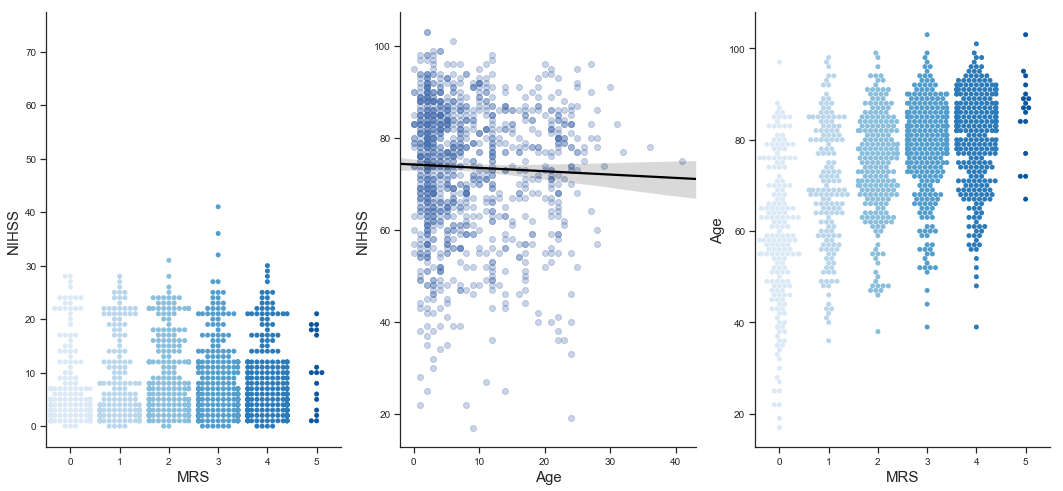

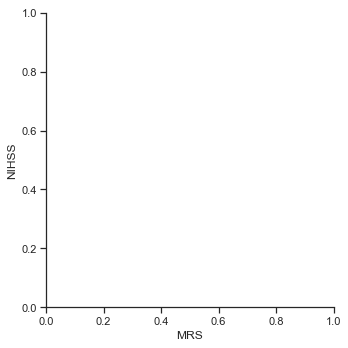

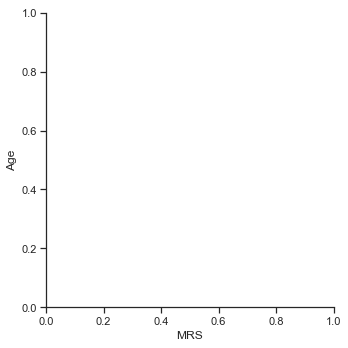

In [110]:

_plot_style = sns.axes_style()

_plot_style['axes.spines.right'] = False
_plot_style['axes.spines.top'] = False

f, axes = plt.subplots(1, 3, figsize=(full_figure_width, figure_height))
sns.set_style(_plot_style)


sns.catplot(x="MRS", y="NIHSS", kind="swarm", data=df, ax=axes[0], palette='Blues')
plt.sca(axes[0])
plt.xlabel("MRS",fontsize=_xlabel_size)
plt.ylabel('NIHSS', fontsize=_ylabel_size)
plt.tick_params(axis='both', which='major', labelsize=10)
sns.despine()


sns.regplot(x="NIHSS", y="Age", data=df, ax=axes[1], line_kws={"color": "black"}, scatter_kws={'alpha':0.3})
plt.sca(axes[1])
plt.xlabel("Age",fontsize=_xlabel_size)
plt.ylabel('NIHSS', fontsize=_ylabel_size)
plt.tick_params(axis='both', which='major', labelsize=10)
sns.despine()


sns.catplot(x="MRS", y="Age", kind="swarm", data=df, ax=axes[2], palette='Blues')
plt.sca(axes[2])
plt.xlabel("MRS",fontsize=_xlabel_size)
plt.ylabel('Age', fontsize=_ylabel_size)
plt.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

plt.show()

with open('figures/fig2.png', 'wb') as fileout:
    f.savefig(fileout, bbox_inches='tight')



## Separating predictors by group

### NIHSS

NIHSS seems to have clear signal. Higher NIHSS scores are bad news.

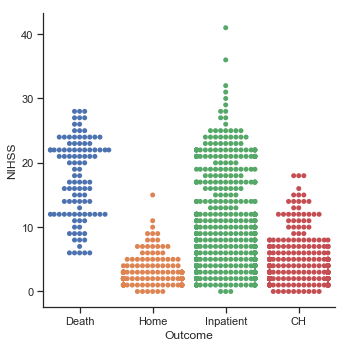

In [111]:
sns.catplot(x="Outcome", y="NIHSS", kind="swarm", data=df)
plt.show()

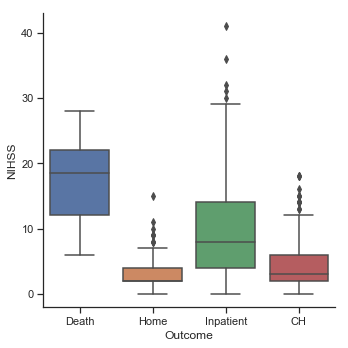

In [112]:
sns.catplot(x="Outcome", y="NIHSS", kind="box", data=df)
plt.show()

### MRS

Home is associated with **lower** MRS scores.

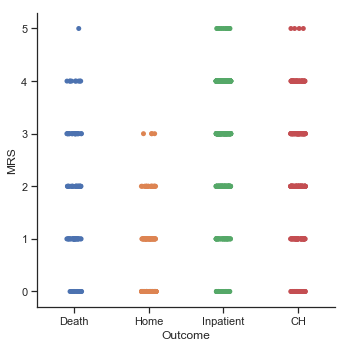

In [113]:
sns.catplot(x="Outcome", y="MRS", data=df, jitter=1)

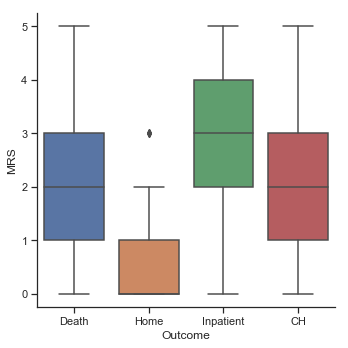

In [114]:
sns.catplot(x="Outcome", y="MRS", kind="box", data=df)

Makes more sense to look at MRS as a categorical variable.

In [115]:
dbl_count = df.groupby(['MRS', 'Outcome'])['Age'].count()
dbl_count

MRS  Outcome  
0    CH            37
     Death         13
     Home         100
     Inpatient     37
1    CH            48
     Death         31
     Home          46
     Inpatient     33
2    CH            82
     Death         28
     Home          21
     Inpatient     92
3    CH            83
     Death         24
     Home           4
     Inpatient    165
4    CH            45
     Death          9
     Inpatient    216
5    CH             4
     Death          1
     Inpatient     12
Name: Age, dtype: int64

### Age

Age does not seem particularly related, although young people are rarely sent home after stroke:

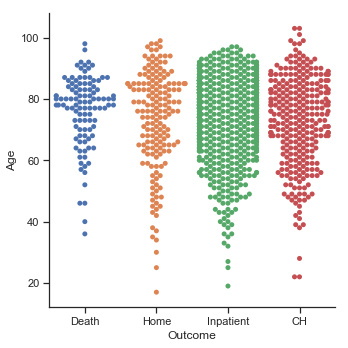

In [116]:
sns.catplot(x="Outcome", y="Age", kind="swarm", data=df)

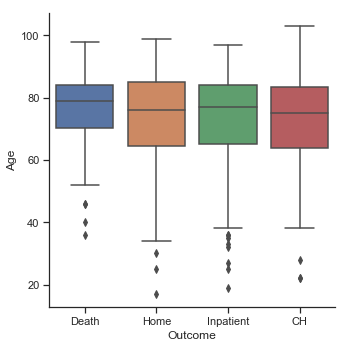

In [117]:
sns.catplot(x="Outcome", y="Age", kind="box", data=df)

# Figure 1

In [118]:
!pip install ptitprince==0.1.3

You are using pip version 9.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [119]:
full_figure_width = 18
figure_height = 8

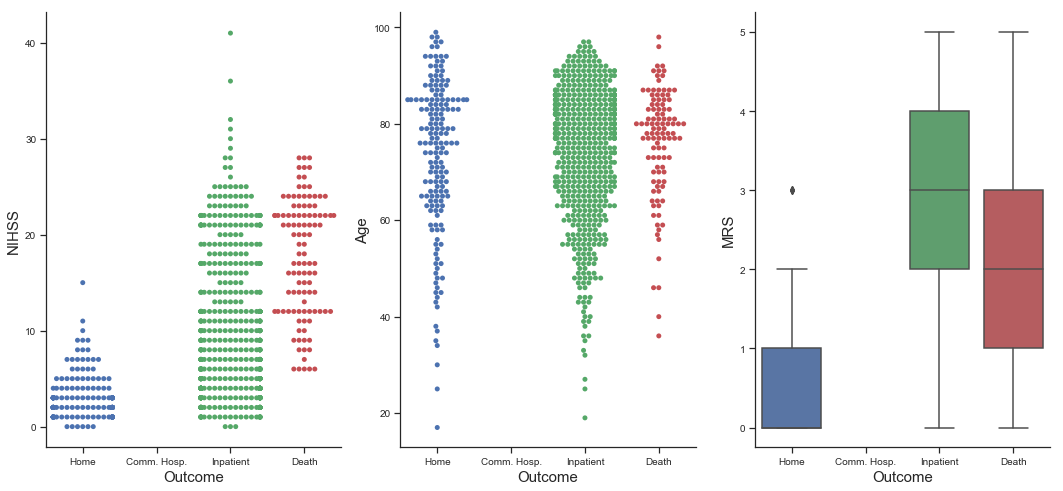

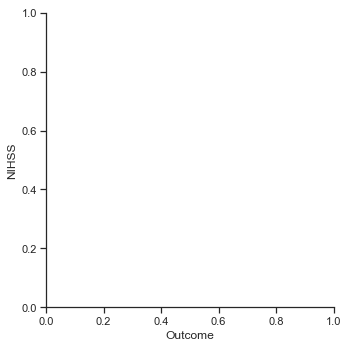

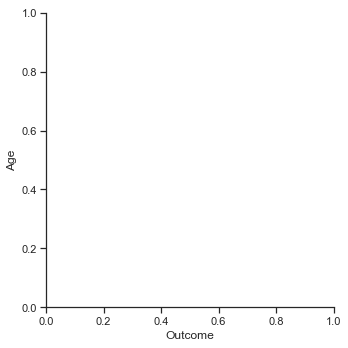

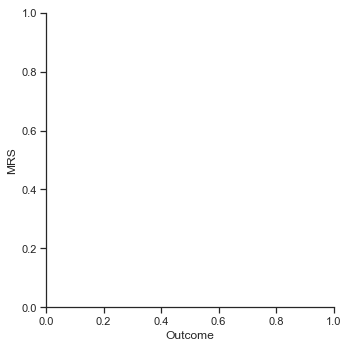

In [120]:
_xlabel_size = 15
_ylabel_size = 15

_plot_style = sns.axes_style()

_plot_style['axes.spines.right'] = False
_plot_style['axes.spines.top'] = False

f, axes = plt.subplots(1, 3, figsize=(full_figure_width, figure_height))
sns.set_style(_plot_style)


cp1 = sns.catplot(x="Outcome", y="NIHSS", kind="swarm", data=df, ax=axes[0], order=order)
plt.sca(axes[0])
plt.xlabel("Outcome",fontsize=_xlabel_size)
plt.ylabel('NIHSS', fontsize=_ylabel_size)
plt.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

sns.catplot(x="Outcome", y="Age", kind="swarm", data=df, ax=axes[1], order=order)
plt.sca(axes[1])
plt.xlabel("Outcome",fontsize=_xlabel_size)
plt.ylabel('Age', fontsize=_ylabel_size)
plt.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

sns.catplot(x="Outcome", y="MRS", kind="box", data=df, ax=axes[2], order=order)
plt.sca(axes[2])
plt.xlabel("Outcome",fontsize=_xlabel_size)
plt.ylabel('MRS', fontsize=_ylabel_size)
plt.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

plt.show()

with open('figures/fig1.png', 'wb') as fileout:
    f.savefig(fileout, bbox_inches='tight')


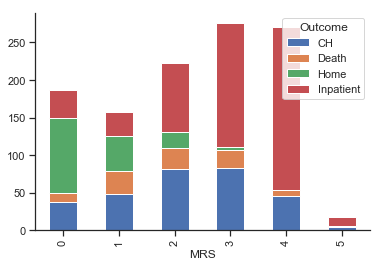

In [121]:
df_plot = df.groupby(['MRS', 'Outcome']).size().reset_index().pivot(columns='Outcome', index='MRS', values=0).plot(kind='bar', stacked=True)

In [122]:
countby_MRS = df.groupby(['MRS', 'Outcome'])['MRS'].count().unstack(fill_value=0).stack()

In [123]:
countby_MRS

MRS  Outcome  
0    CH            37
     Death         13
     Home         100
     Inpatient     37
1    CH            48
     Death         31
     Home          46
     Inpatient     33
2    CH            82
     Death         28
     Home          21
     Inpatient     92
3    CH            83
     Death         24
     Home           4
     Inpatient    165
4    CH            45
     Death          9
     Home           0
     Inpatient    216
5    CH             4
     Death          1
     Home           0
     Inpatient     12
dtype: int64

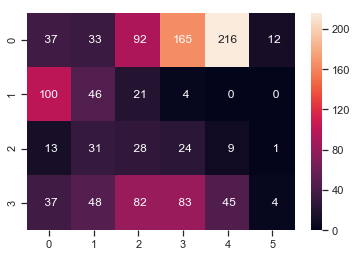

In [124]:
sns.heatmap(np.flip(countby_MRS.values.reshape(6, 4).T, axis=0), 
            annot=True, fmt='3g')

## 2. Univariate stats


ANOVAs/KW confirm that MRS and NIHSS both have signal about destination, whereas age alone does not.

In [125]:
def compute_kruskal(df, factor):
    F, p = stats.kruskal(df.loc[df['Outcome']=='Home',factor], 
                      df.loc[df['Outcome']=='Death',factor], 
                      df.loc[df['Outcome']=='CH',factor], 
                      df.loc[df['Outcome']=='Inpatient',factor]) 
    return F, p

def compute_pairwise_p(df, factor):
    outcomes = df.Outcome.unique()
    p_mtx = np.zeros((len(outcomes), len(outcomes))) 
    for i, o1 in enumerate(outcomes):
        for j, o2 in enumerate(outcomes):
             _ , p_mtx[i, j]= stats.ttest_ind(df.loc[df['Outcome']==o1, factor],
               df.loc[df['Outcome']==o2, factor])
            
    return p_mtx, outcomes
         
def univariate_stats(df, factor):
    F, p = compute_kruskal(df, factor)
    
    print(f"{factor}, p={p} from Kruskal Wallace")
    p_MRS, outcomes = compute_pairwise_p(df, factor)
    mask = np.zeros_like(p_MRS)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(p_MRS, xticklabels=outcomes, yticklabels=outcomes, mask=mask, annot=True, linewidths=.5)
    
    plt.title(factor)
    plt.show()
    

### MRS

MRS, p=6.1999280091603114e-77 from Kruskal Wallace


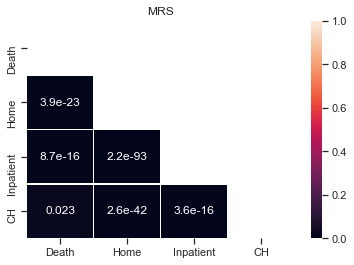

In [126]:
univariate_stats(df, "MRS")

### NIHSS

NIHSS, p=2.2336536835462652e-84 from Kruskal Wallace


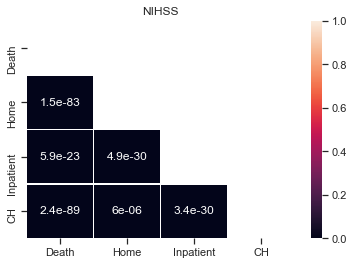

In [127]:
univariate_stats(df, "NIHSS")

### Age

Age, p=0.23081639125831246 from Kruskal Wallace


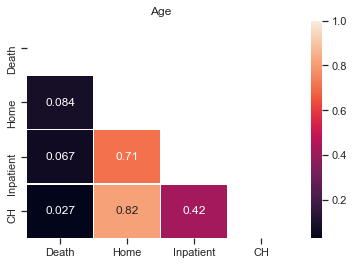

In [128]:
univariate_stats(df, "Age")


This implies that the age of people who die after stroke may be slightly different from each of the other outcomes, but that the other outcomes do not differ between themselves.

# 3. Splitting analysis by MRS level 

We are going to analyse the relationship between age, NIHSS, and outcome independently for each level of the MRS. For a reminder, these are what the levels are described as:

- 0 - No symptoms.
- 1 - No significant disability. Able to carry out all usual activities, despite some symptoms.
- 2 - Slight disability. Able to look after own affairs without assistance, but unable to carry out all previous activities.
- 3 - Moderate disability. Requires some help, but able to walk unassisted.
- 4 - Moderately severe disability. Unable to attend to own bodily needs without assistance, and unable to walk unassisted.
- 5 - Severe disability. Requires constant nursing care and attention, bedridden, incontinent.
- 6 - Dead.

#### Does the relationship between Age and NIHSS differ for each level of MRS?

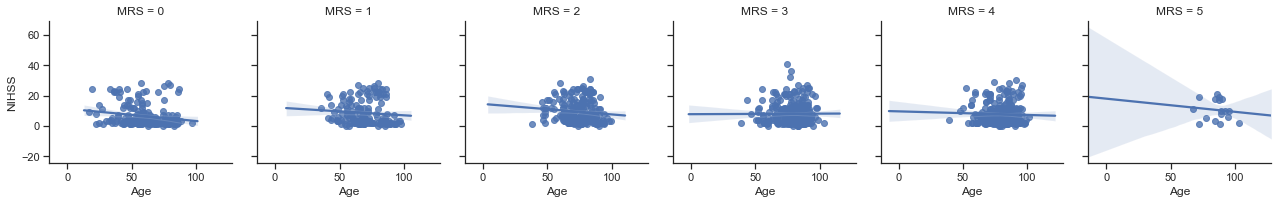

In [129]:
g = sns.FacetGrid(df, col="MRS")
g.map(sns.regplot, "Age", 'NIHSS')
plt.show()


#### Does the relationship between Age and Outcome differ for each level of MRS?

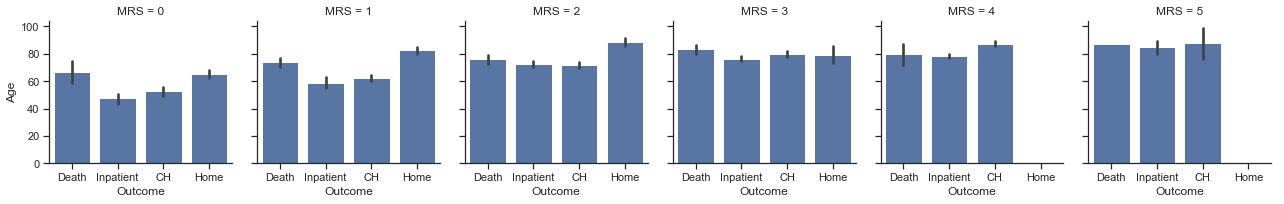

In [130]:
g = sns.FacetGrid(df, col="MRS")
g.map(sns.barplot, "Outcome", 'Age', order=['Death', 'Inpatient','CH', 'Home'])
plt.show()

Quite subtle. So the average age of somebody who dies with an MRS score of 0 is notably higher than that of somebody who ends up as an inpatient with MRS score of 0. This could be seen as a statement about volatility. 

As you increase the MRS score, age differences seem to flatten out.

#### Does the relationship between NIHSS and Outcome differ for each level of MRS?

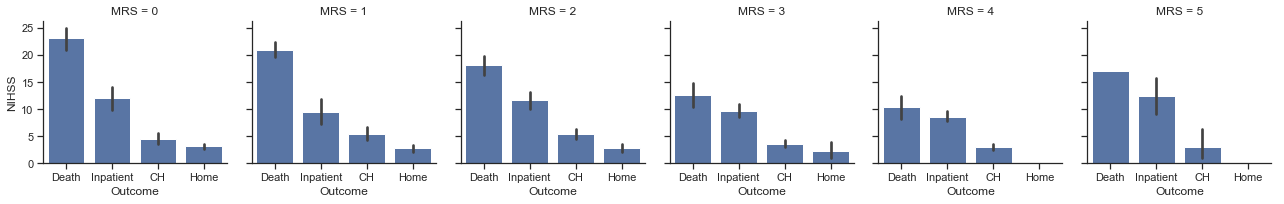

In [131]:
g = sns.FacetGrid(df, col="MRS")
g.map(sns.barplot, "Outcome", 'NIHSS', order=['Death', 'Inpatient','CH', 'Home'])
plt.show()

Having a high NIHSS score is clearly bad news regardless of your MRS rating. NIHSS appears to be informative of outcome for every level of the MRS, demonstrating that the two carry different types of information.

## Visualizing correlations for each outcome

# Figure 2b

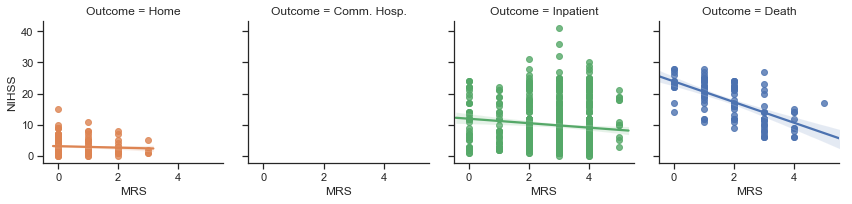

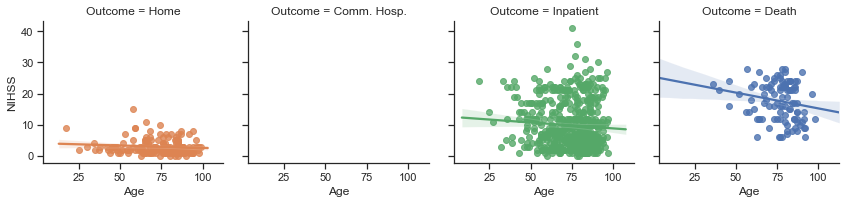

In [132]:

g = sns.FacetGrid(df, col="Outcome", hue="Outcome", col_order=order)
r_plots = g.map(sns.regplot, "MRS", 'NIHSS')

for ax in r_plots.axes[:,0]:
    ax.set_xlim((-.5, 5.5))

with open('figures/fig2bi.png', 'wb') as fileout:
    g.fig.savefig(fileout, bbox_inches='tight')
    
g = sns.FacetGrid(df, col="Outcome", hue="Outcome", col_order=order)
r_plots = g.map(sns.regplot, "Age", 'NIHSS')

with open('figures/fig2bii.png', 'wb') as fileout:
    g.fig.savefig(fileout, bbox_inches='tight')



Indeed, for death NIHSS and MRS are negatively correlated:

In [133]:
r = df[df['Outcome']=='Death'].corr()
r, p = stats.pearsonr(df.loc[df['Outcome']=='Death','MRS'].values,
               df.loc[df['Outcome']=='Death','NIHSS'].values)
print(r, p)

-0.6513546918855714 4.025539700422566e-14


In [134]:
r, p = stats.pearsonr(df.loc[df['Outcome']=='Inpatient','MRS'].values,
               df.loc[df['Outcome']=='Inpatient','NIHSS'].values)
print(r, p)

-0.11772110955440918 0.005490817068340396


In [135]:
r, p = stats.pearsonr(df.loc[df['Outcome']=='Comm. Hosp.','MRS'].values,
               df.loc[df['Outcome']=='Comm. Hosp.','NIHSS'].values)
print(r, p)

nan nan


/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/scipy/stats/stats.py:3005: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/scipy/stats/stats.py:3006: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [136]:
r, p = stats.pearsonr(df.loc[df['Outcome']=='Home','MRS'].values,
               df.loc[df['Outcome']=='Home','NIHSS'].values)
print(r, p)

-0.0812032166245912 0.29104766234067003


Marginal for age, won't survive multiple comparisons

In [137]:
r = df[df['Outcome']=='Death'].corr()
r, p = stats.pearsonr(df.loc[df['Outcome']=='Death','Age'].values,
               df.loc[df['Outcome']=='Death','NIHSS'].values)
print(p)

0.048558478140595114


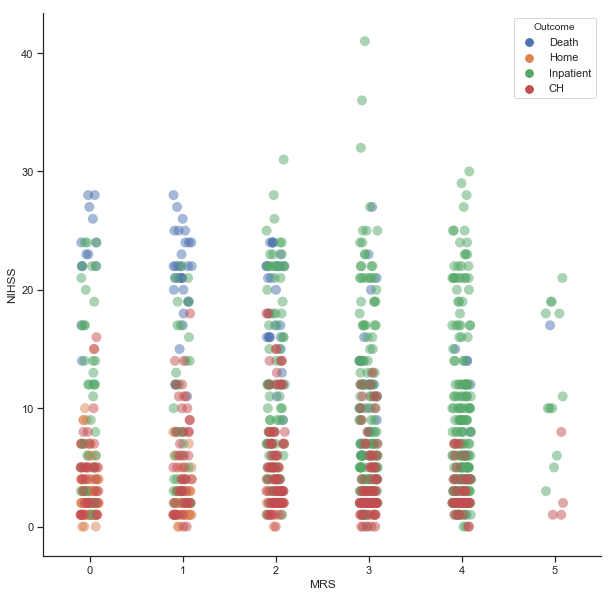

In [138]:
plt.figure(figsize=(10,10))
sns.stripplot(x='MRS', y='NIHSS', hue='Outcome', data=df, alpha=.5, size=10)

# 4. Building simple predictive models

In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.dummy import DummyClassifier

In [140]:
lm = LogisticRegression(multi_class='multinomial', solver='saga', class_weight='balanced')

# Split the data, with stratified sampling

In [141]:
def stratified_sample_df(df, col, frac, random_state=1234):
    if frac > 1.:
        raise ValueError
        
    original_numbers = df[col].value_counts()
    sample_n = {k: int(v * frac) for k, v in original_numbers.items()}

    df_ = df.groupby(col).apply(lambda x: x.sample(sample_n[x.name], random_state=random_state))
    df_.index = df_.index.droplevel(0)

    return df_

In [142]:
train_frac = 0.9
test_frac = 0.1

In [143]:
df_train = stratified_sample_df(df, col='Outcome', frac=train_frac, random_state=1234)

In [144]:
df_test = df.loc[df.index.difference(df_train.index)]

Confirm that both train and test have a similar distribution over classes:

Text(0.5, 1.0, 'Train')

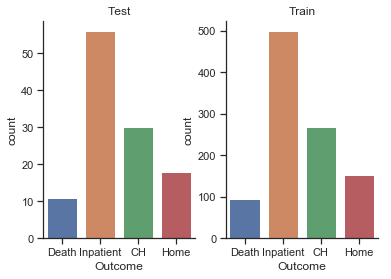

In [145]:
plt.subplot(121)
sns.countplot(x='Outcome', data=df_test, order=['Death', 'Inpatient', 'CH', 'Home'])
plt.title('Test')
plt.subplot(122)
sns.countplot(x='Outcome', data=df_train, order=['Death', 'Inpatient', 'CH', 'Home'])
plt.title('Train')

## Dummy model

Reminder of the class imbalance

In [146]:
df_train['Outcome'].value_counts()

Inpatient    499
CH           269
Home         153
Death         95
Name: Outcome, dtype: int64

In [147]:
dm = DummyClassifier(strategy='prior')

In [148]:
X = pd.get_dummies(df_train['MRS'])
y = df_train['Outcome'].map({v:k for k,v in outcome_dict.items()}).values

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

{'fit_time': array([0.00189114, 0.00160098, 0.00125098, 0.00122976, 0.00112605,
       0.00182033, 0.00189805, 0.00154805, 0.00170279, 0.00157189]),
 'score_time': array([0.00172496, 0.00221992, 0.00132298, 0.00127625, 0.00185895,
       0.0014956 , 0.00155687, 0.00143886, 0.00137305, 0.00114298]),
 'test_accuracy': array([0.48543689, 0.48543689, 0.48543689, 0.49019608, 0.49019608,
       0.4950495 , 0.4950495 , 0.4950495 , 0.4950495 , 0.49494949]),
 'test_f1_macro': array([0.16339869, 0.16339869, 0.16339869, 0.16447368, 0.16447368,
       0.16556291, 0.16556291, 0.16556291, 0.16556291, 0.16554054]),
 'train_accuracy': array([0.49178532, 0.49178532, 0.49178532, 0.49124726, 0.49124726,
       0.49071038, 0.49071038, 0.49071038, 0.49071038, 0.49073064]),
 'train_f1_macro': array([0.16483113, 0.16483113, 0.16483113, 0.1647102 , 0.1647102 ,
       0.16458944, 0.16458944, 0.16458944, 0.16458944, 0.164594  ])}


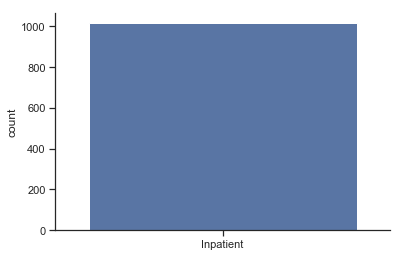

In [149]:
pprint(cross_validate(dm, X, y, scoring=('accuracy', 'f1_macro'), cv=10))
y_pred = cross_val_predict(dm, X, y, cv=5)
sns.countplot([outcome_dict[yy] for yy in y_pred])
plt.show()

## MRS

In [150]:
X = pd.get_dummies(df_train['MRS']).values

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

{'fit_time': array([0.02135491, 0.01623201, 0.01569605, 0.03442001, 0.04320002]),
 'score_time': array([0.00279713, 0.00250888, 0.00301576, 0.01519299, 0.00469923]),
 'test_accuracy': array([0.51470588, 0.56372549, 0.51470588, 0.44334975, 0.55721393]),
 'test_f1_macro': array([0.40556042, 0.41415249, 0.36785293, 0.33597445, 0.39677406]),
 'test_f1_micro': array([0.51470588, 0.56372549, 0.51470588, 0.44334975, 0.55721393]),
 'train_accuracy': array([0.53817734, 0.54802956, 0.50123153, 0.49692497, 0.54969325]),
 'train_f1_macro': array([0.45601102, 0.39269067, 0.36084953, 0.38177633, 0.39719197]),
 'train_f1_micro': array([0.53817734, 0.54802956, 0.50123153, 0.49692497, 0.54969325])}


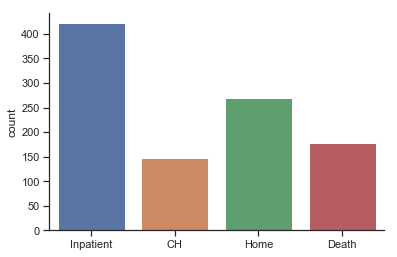

In [151]:
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
pprint(scores)
y_pred = cross_val_predict(lm, X, y)
sns.countplot([outcome_dict[yy] for yy in y_pred])
plt.show()

## NIHSS

A simple logistic regression works poorly:

In [152]:
lm = LogisticRegression(multi_class='multinomial', solver='saga')

In [153]:
X = df_train['NIHSS'].values.reshape(-1,1)
X = stats.zscore(X)
X

array([[-0.29608723],
       [-0.85009206],
       [-0.15758602],
       ...,
       [-0.57308964],
       [ 1.78143089],
       [ 0.1194164 ]])

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

{'fit_time': array([0.00787497, 0.00637221, 0.00594521, 0.00615406, 0.00539613]),
 'score_time': array([0.00544   , 0.00291991, 0.00285387, 0.00321412, 0.00188279]),
 'test_accuracy': array([0.51470588, 0.5245098 , 0.5245098 , 0.51231527, 0.49751244]),
 'test_f1_macro': array([0.27823465, 0.28069627, 0.29500726, 0.30090822, 0.2693649 ]),
 'test_f1_micro': array([0.51470588, 0.5245098 , 0.5245098 , 0.51231527, 0.49751244]),
 'train_accuracy': array([0.51847291, 0.52093596, 0.52093596, 0.52644526, 0.52515337]),
 'train_f1_macro': array([0.29350308, 0.28265319, 0.30217918, 0.30611857, 0.324227  ]),
 'train_f1_micro': array([0.51847291, 0.52093596, 0.52093596, 0.52644526, 0.52515337])}


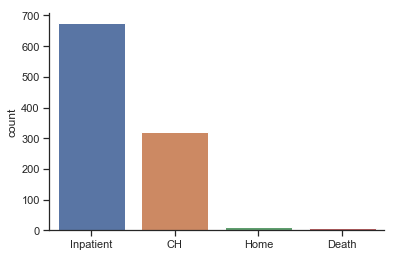

In [154]:
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
pprint(scores)
y_pred = cross_val_predict(lm, X, y)
sns.countplot([outcome_dict[yy] for yy in y_pred])
plt.show()

#### Try using NIHSS as categorical variable

In [155]:
X = pd.get_dummies(df_train['NIHSS'])

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

{'fit_time': array([0.0402801 , 0.10659909, 0.04611111, 0.03786302, 0.04166198]),
 'score_time': array([0.0055151 , 0.00673008, 0.00474286, 0.00335073, 0.00536895]),
 'test_accuracy': array([0.53921569, 0.52941176, 0.50980392, 0.50246305, 0.49751244]),
 'test_f1_macro': array([0.30664179, 0.27167565, 0.2841199 , 0.30250784, 0.24829109]),
 'test_f1_micro': array([0.53921569, 0.52941176, 0.50980392, 0.50246305, 0.49751244]),
 'train_accuracy': array([0.52955665, 0.52955665, 0.53571429, 0.53259533, 0.5398773 ]),
 'train_f1_macro': array([0.28337938, 0.27321048, 0.34900101, 0.34470283, 0.29794174]),
 'train_f1_micro': array([0.52955665, 0.52955665, 0.53571429, 0.53259533, 0.5398773 ])}


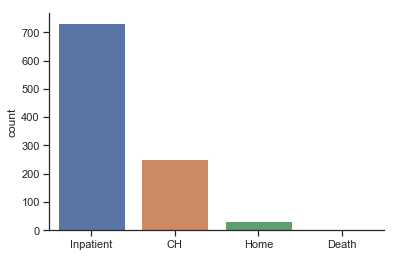

In [156]:
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
pprint(scores)
y_pred = cross_val_predict(lm, X, y, cv=5)
sns.countplot([outcome_dict[yy] for yy in y_pred])
plt.show()

What do the parameters actually look like in this model?

In [157]:
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5, return_estimator=True)

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

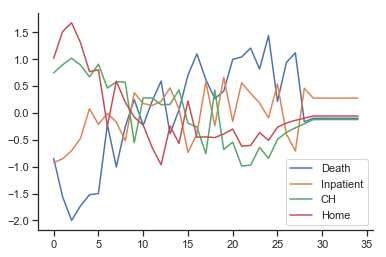

In [158]:
est = scores['estimator'][0]
plt.plot(est.coef_.T)
plt.legend(list(outcome_dict.values()))

Are we regularizating too much?

In [159]:
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

In [160]:
pprint(scores)

{'fit_time': array([0.04233885, 0.03243494, 0.03247285, 0.02862692, 0.03151107]),
 'score_time': array([0.00459695, 0.00378895, 0.0040524 , 0.00385118, 0.00422192]),
 'test_accuracy': array([0.53921569, 0.52941176, 0.50980392, 0.50246305, 0.49751244]),
 'test_f1_macro': array([0.30664179, 0.27167565, 0.2841199 , 0.30250784, 0.24829109]),
 'test_f1_micro': array([0.53921569, 0.52941176, 0.50980392, 0.50246305, 0.49751244]),
 'train_accuracy': array([0.52955665, 0.52955665, 0.53571429, 0.53259533, 0.5398773 ]),
 'train_f1_macro': array([0.28337938, 0.27321048, 0.34900101, 0.34470283, 0.29794174]),
 'train_f1_micro': array([0.52955665, 0.52955665, 0.53571429, 0.53259533, 0.5398773 ])}


Confusion matrix, without normalization
[[  1  94   0   0]
 [  1 418  72   8]
 [  0 155  98  16]
 [  0  65  81   7]]


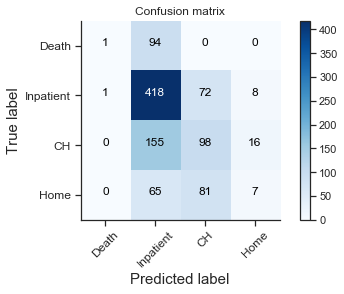

In [161]:
plot_confusion_matrix(confusion_matrix(y, y_pred), classes=outcome_dict.values())

#### What is the effect of balancing the classes?

{'fit_time': array([0.00869513, 0.00706697, 0.00947976, 0.0080514 , 0.00856519]),
 'score_time': array([0.00272989, 0.00266576, 0.00282407, 0.00205183, 0.00255919]),
 'test_accuracy': array([0.35784314, 0.40196078, 0.37745098, 0.33004926, 0.40298507]),
 'test_f1_macro': array([0.36389507, 0.40602662, 0.38029093, 0.32499734, 0.40254386]),
 'test_f1_micro': array([0.35784314, 0.40196078, 0.37745098, 0.33004926, 0.40298507]),
 'train_accuracy': array([0.37807882, 0.36699507, 0.37315271, 0.38499385, 0.36687117]),
 'train_f1_macro': array([0.37829947, 0.36801644, 0.37425016, 0.38813373, 0.36871771]),
 'train_f1_micro': array([0.37807882, 0.36699507, 0.37315271, 0.38499385, 0.36687117])}


/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


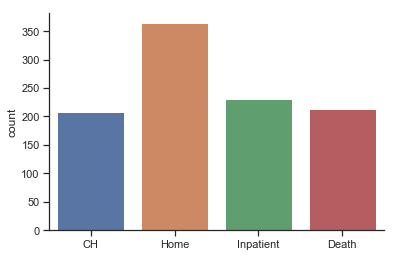

Confusion matrix, without normalization
[[ 65  26   4   0]
 [136 140 116 107]
 [ 12  51  62 144]
 [  1  14  25 113]]


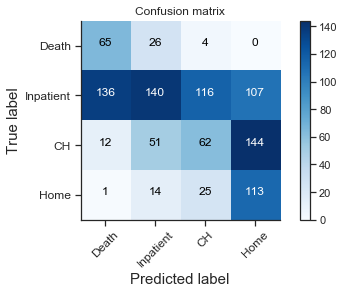

In [162]:
lm = LogisticRegression(multi_class='multinomial', solver='saga', class_weight='balanced')
X = df_train['NIHSS'].values.reshape(-1,1)
X = stats.zscore(X)
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
pprint(scores)
y_pred = cross_val_predict(lm, X, y)
sns.countplot([outcome_dict[yy] for yy in y_pred])
plt.show()

plot_confusion_matrix(confusion_matrix(y, y_pred), classes=outcome_dict.values())

The confusion matrices look much better if you balance, but the raw accuracy is poorer - the test accuracy is *worse* than the dummy classifier

## Age

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

{'fit_time': array([0.00907683, 0.01012397, 0.00921988, 0.01127911, 0.00966191]),
 'score_time': array([0.0034771 , 0.00312877, 0.0030911 , 0.00250983, 0.0030961 ]),
 'test_accuracy': array([0.49019608, 0.49019608, 0.49019608, 0.49261084, 0.49253731]),
 'test_f1_macro': array([0.16447368, 0.16447368, 0.16447368, 0.1650165 , 0.165     ]),
 'test_f1_micro': array([0.49019608, 0.49019608, 0.49019608, 0.49261084, 0.49253731]),
 'train_accuracy': array([0.49137931, 0.49137931, 0.49137931, 0.49077491, 0.49079755]),
 'train_f1_macro': array([0.16473988, 0.16473988, 0.16473988, 0.16460396, 0.16460905]),
 'train_f1_micro': array([0.49137931, 0.49137931, 0.49137931, 0.49077491, 0.49079755])}


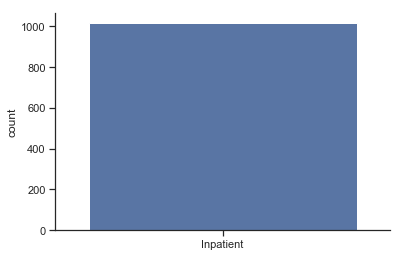

Confusion matrix, without normalization
[[  0  95   0   0]
 [  0 499   0   0]
 [  0 269   0   0]
 [  0 153   0   0]]


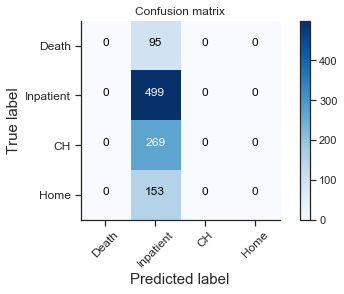

In [163]:
lm = LogisticRegression(multi_class='multinomial', solver='saga')
X = df_train['Age'].values.reshape(-1,1)
X = stats.zscore(X)
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
pprint(scores)
y_pred = cross_val_predict(lm, X, y)
sns.countplot([outcome_dict[yy] for yy in y_pred])
plt.show()

plot_confusion_matrix(confusion_matrix(y, y_pred), classes=outcome_dict.values())

Basically no signal in age - it collapses to predicting the majority class

So to round up, if we don't try and balance the classes, we get something like this:

In [164]:
best_rf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=3)

In [165]:
CROSS_VAL=100
collated_scores = {}

dm = DummyClassifier(strategy='prior')
X = pd.get_dummies(df_train['MRS'])
scores = cross_validate(dm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=CROSS_VAL)
collated_scores['dummy'] = scores['test_accuracy']

X = pd.get_dummies(df_train['MRS'])
scores = cross_validate(best_rf, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=CROSS_VAL)
collated_scores['MRS'] = scores['test_accuracy']

X = df_train['NIHSS'].values.reshape(-1,1)
X = stats.zscore(X)
scores = cross_validate(best_rf, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=CROSS_VAL)
collated_scores['NIHSS'] = scores['test_accuracy']


X = df_train['Age'].values.reshape(-1,1)
X = stats.zscore(X)
scores = cross_validate(best_rf, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=CROSS_VAL)
collated_scores['Age'] = scores['test_accuracy']


/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 95 members, which is too few. The minimum number of members in any class cannot be less than n_splits=100.
  % (min_groups, self.n_splits)), Warning)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


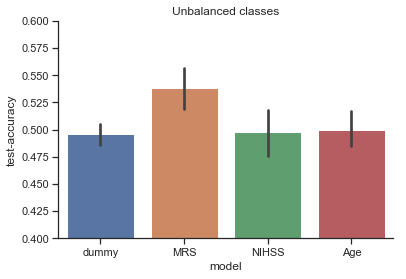

In [166]:
flat = []
for key, value in collated_scores.items():
    for item in value:
        flat.append({key:item})
performance = pd.DataFrame.from_records(flat)
performance['model'] = performance.apply(lambda x: x.idxmax(axis=1), axis=1)
performance['test-accuracy'] = performance.apply(lambda x: x[['Age', 'MRS', 'dummy', 'NIHSS']].max(), axis=1)

performance = performance[['model', 'test-accuracy']]
sns.barplot(x='model', y='test-accuracy', data=performance)
plt.title('Unbalanced classes')
plt.ylim((0.4, 0.6))
plt.show()

And if we do:

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

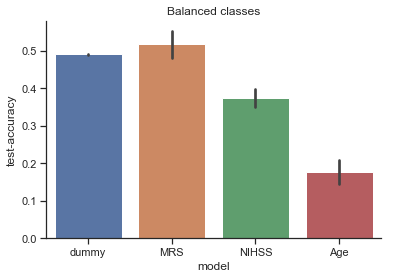

In [167]:
collated_scores = {}

dm = DummyClassifier(strategy='prior')
X = pd.get_dummies(df_train['MRS'])
scores = cross_validate(dm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
collated_scores['dummy'] = scores['test_accuracy']

lm = LogisticRegression(multi_class='multinomial', solver='saga', class_weight='balanced')
X = pd.get_dummies(df_train['MRS'])
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
collated_scores['MRS'] = scores['test_accuracy']

lm = LogisticRegression(multi_class='multinomial', solver='saga', class_weight='balanced')
X = df_train['NIHSS'].values.reshape(-1,1)
X = stats.zscore(X)
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
collated_scores['NIHSS'] = scores['test_accuracy']

lm = LogisticRegression(multi_class='multinomial', solver='saga', class_weight='balanced')
X = df_train['Age'].values.reshape(-1,1)
X = stats.zscore(X)
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
collated_scores['Age'] = scores['test_accuracy']


flat = []
for key, value in collated_scores.items():
    for item in value:
        flat.append({key:item})
performance = pd.DataFrame.from_records(flat)
performance['model'] = performance.apply(lambda x: x.idxmax(axis=1), axis=1)
performance['test-accuracy'] = performance.apply(lambda x: x[['Age', 'MRS', 'dummy', 'NIHSS']].max(), axis=1)

performance = performance[['model', 'test-accuracy']]
sns.barplot(x='model', y='test-accuracy', data=performance)
plt.title('Balanced classes')
plt.show()

### Using pairs 

In [168]:
def run_model(X, class_weight=None, rf=None):
    if rf is None:
        rf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=3)
        
    scores = cross_validate(rf, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=CROSS_VAL)
    # collated_scores['NIHSS'] = scores['test_accuracy']
    pprint(scores)
    y_pred = cross_val_predict(rf, X, y)
    sns.countplot([outcome_dict[yy] for yy in y_pred])
    plt.show()

    plot_confusion_matrix(confusion_matrix(y, y_pred), classes=outcome_dict.values())
    return scores

### Age and NIHSS

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 95 members, which is too few. The minimum number of members in any class cannot be less than n_splits=100.
  % (min_groups, self.n_splits)), Warning)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and

{'fit_time': array([0.1544888 , 0.1231339 , 0.11497116, 0.11666727, 0.12550402,
       0.12476802, 0.10881996, 0.12002587, 0.11838388, 0.13191319,
       0.1203649 , 0.12861109, 0.13682723, 0.12374592, 0.11924005,
       0.14040112, 0.11911416, 0.1282208 , 0.13684392, 0.1177671 ,
       0.11415172, 0.12315392, 0.12432218, 0.1180532 , 0.13311625,
       0.13329697, 0.1075058 , 0.11885786, 0.13374281, 0.11087298,
       0.12115192, 0.11599827, 0.11523509, 0.12028503, 0.10716486,
       0.11712098, 0.11796403, 0.12039709, 0.13128996, 0.11295009,
       0.11818314, 0.1229291 , 0.12036896, 0.13143086, 0.11399508,
       0.11448503, 0.11813617, 0.12387133, 0.12071776, 0.11495805,
       0.12037611, 0.12358499, 0.13275099, 0.12586498, 0.13075209,
       0.12197781, 0.11167383, 0.12129402, 0.12315488, 0.12482405,
       0.13327312, 0.11575794, 0.12559175, 0.1254189 , 0.12410498,
       0.10011721, 0.11882305, 0.11712408, 0.11680818, 0.11872721,
       0.12345695, 0.11644697, 0.12679291, 0.1240

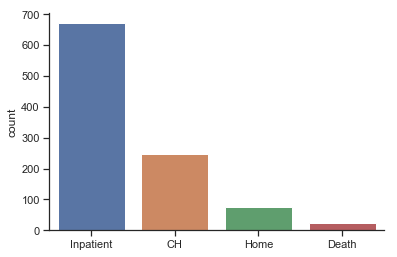

Confusion matrix, without normalization
[[ 10  85   0   0]
 [ 11 392  78  18]
 [  2 131 102  34]
 [  0  63  68  22]]


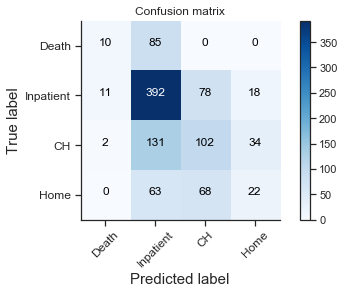

In [169]:
X = df_train[['Age', 'NIHSS']].values.reshape(-1,2)
X = stats.zscore(X)
scores = run_model(X)
collated_scores['Age + NIHSS'] = scores['test_accuracy']

### Age and MRS

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 95 members, which is too few. The minimum number of members in any class cannot be less than n_splits=100.
  % (min_groups, self.n_splits)), Warning)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and

{'fit_time': array([0.14996696, 0.15914512, 0.15009618, 0.19566298, 0.15431094,
       0.1470511 , 0.17481589, 0.17541504, 0.19718385, 0.285923  ,
       0.14398479, 0.16995788, 0.25591779, 0.15962195, 0.17846179,
       0.21070814, 0.17440486, 0.17198324, 0.19882822, 0.15743399,
       0.15553093, 0.16523504, 0.17623806, 0.13849688, 0.13865614,
       0.133322  , 0.13301802, 0.15129995, 0.15832496, 0.17179275,
       0.14049983, 0.14227605, 0.18253493, 0.13702512, 0.14045286,
       0.15655303, 0.16770267, 0.14885712, 0.17415571, 0.18567514,
       0.144768  , 0.14903283, 0.17852902, 0.16793489, 0.14386415,
       0.15811729, 0.14926696, 0.15905619, 0.15605712, 0.18279505,
       0.13538718, 0.13295126, 0.16009378, 0.13772202, 0.1137991 ,
       0.11929417, 0.11890507, 0.12367988, 0.12011218, 0.12010598,
       0.11343002, 0.1167891 , 0.12441587, 0.11469293, 0.12176323,
       0.11077619, 0.11167192, 0.11687303, 0.12668228, 0.1150732 ,
       0.12509894, 0.12261295, 0.10631299, 0.1214

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


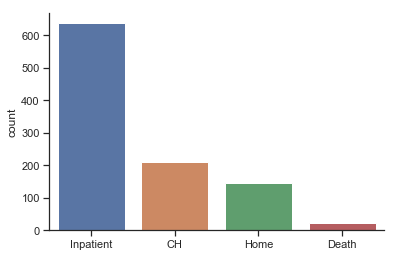

Confusion matrix, without normalization
[[ 12  49  19  15]
 [  4 406  71  18]
 [  2 161  88  18]
 [  5  21  32  95]]


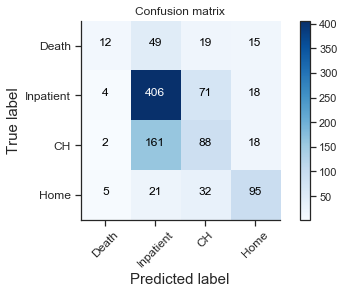

In [170]:
X = df_train['Age'].values.reshape(-1,1)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)
scores = run_model(X)
collated_scores['Age + MRS'] = scores['test_accuracy']

# NIHSS and MRS

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 95 members, which is too few. The minimum number of members in any class cannot be less than n_splits=100.
  % (min_groups, self.n_splits)), Warning)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and

{'fit_time': array([0.13486218, 0.15330005, 0.1055429 , 0.1012249 , 0.11588788,
       0.11047506, 0.10891008, 0.09476709, 0.11208081, 0.1070962 ,
       0.11131883, 0.11781597, 0.10769606, 0.11046505, 0.11845994,
       0.10147405, 0.11109662, 0.10871005, 0.11615419, 0.11183715,
       0.11357427, 0.10841393, 0.09643102, 0.10998297, 0.10805416,
       0.12567711, 0.11190987, 0.10237694, 0.11207318, 0.12830114,
       0.11834407, 0.10826206, 0.10754418, 0.11154914, 0.11502695,
       0.11605906, 0.10936689, 0.10629034, 0.10891819, 0.11669588,
       0.10508513, 0.0961411 , 0.10958219, 0.11317801, 0.118505  ,
       0.1139462 , 0.09492993, 0.11874914, 0.11094689, 0.10399365,
       0.11031508, 0.11492109, 0.11154485, 0.1184001 , 0.10949612,
       0.11447406, 0.11099696, 0.09428811, 0.10585594, 0.1048708 ,
       0.11409116, 0.11286497, 0.10762501, 0.09738708, 0.11429596,
       0.11180639, 0.1052947 , 0.10608721, 0.11006093, 0.11469483,
       0.09682703, 0.1167202 , 0.11559892, 0.0947

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


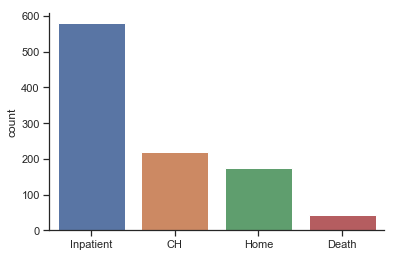

Confusion matrix, without normalization
[[ 30  61   4   0]
 [ 12 398  66  23]
 [  2 115 109  43]
 [  0   6  39 108]]


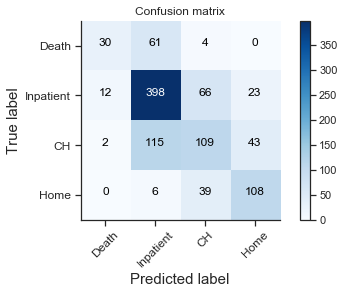

In [171]:
X = df_train['NIHSS'].values.reshape(-1,1)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)
scores = run_model(X)
collated_scores['MRS + NIHSS'] = scores['test_accuracy']

### And the triple whammy

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 95 members, which is too few. The minimum number of members in any class cannot be less than n_splits=100.
  % (min_groups, self.n_splits)), Warning)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and

{'fit_time': array([0.14604902, 0.11598492, 0.12481594, 0.10223985, 0.11800098,
       0.11916399, 0.12310696, 0.11541605, 0.118536  , 0.20277905,
       0.30723   , 0.18943906, 0.28477907, 0.17302227, 0.21269107,
       0.16619015, 0.15620518, 0.13852906, 0.14243412, 0.11049318,
       0.1524179 , 0.17083001, 0.43087411, 0.28682709, 0.32065892,
       0.15090394, 0.12836289, 0.22204113, 0.14230514, 0.13540888,
       0.16833115, 0.18554425, 0.14720607, 0.18925905, 0.16136122,
       0.12823105, 0.1468029 , 0.13856411, 0.14437294, 0.14166713,
       0.14851594, 0.16904807, 0.12376022, 0.15309191, 0.17638397,
       0.12693095, 0.121912  , 0.13525605, 0.13955617, 0.15725899,
       0.15911293, 0.22617388, 0.18072391, 0.1254878 , 0.1338203 ,
       0.123595  , 0.12611198, 0.12163496, 0.12773228, 0.16769099,
       0.12568498, 0.13061619, 0.12127185, 0.17359781, 0.14366627,
       0.12536383, 0.12394786, 0.2501359 , 0.26611519, 0.17422199,
       0.24260616, 0.38118815, 0.252918  , 0.1988

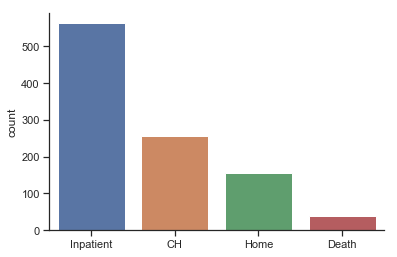

Confusion matrix, without normalization
[[ 30  61   3   1]
 [  9 401  75  14]
 [  1  93 151  24]
 [  0   8  27 118]]


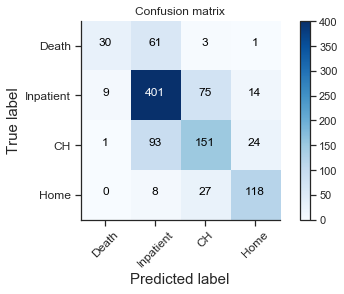

In [172]:
X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)
scores = run_model(X)
[f"{k} {np.mean(v)}" for k,v in scores.items()]

collated_scores['MRS + NIHSS + Age'] = scores['test_accuracy']


## Effect of using multiple predictors

In [173]:
collated_scores.keys()

dict_keys(['dummy', 'MRS', 'NIHSS', 'Age', 'Age + NIHSS', 'Age + MRS', 'MRS + NIHSS', 'MRS + NIHSS + Age'])

In [174]:
collated_scores.keys()

dict_keys(['dummy', 'MRS', 'NIHSS', 'Age', 'Age + NIHSS', 'Age + MRS', 'MRS + NIHSS', 'MRS + NIHSS + Age'])

In [175]:
model_map = {'dummy':0,
            'MRS':1, 
             'NIHSS':1, 
             'Age':1,
             'Age + NIHSS':2,
            'Age + MRS':2,
            'MRS + NIHSS':2,
            'MRS + NIHSS + Age':3}

In [176]:
df_test.MRS.value_counts()

4    30
3    25
2    24
0    22
1    14
Name: MRS, dtype: int64

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(1016, 8)
Normalized confusion matrix
[[0.63636364 0.36363636 0.         0.        ]
 [0.07142857 0.76785714 0.16071429 0.        ]
 [0.         0.26666667 0.66666667 0.06666667]
 [0.         0.         0.11111111 0.88888889]]


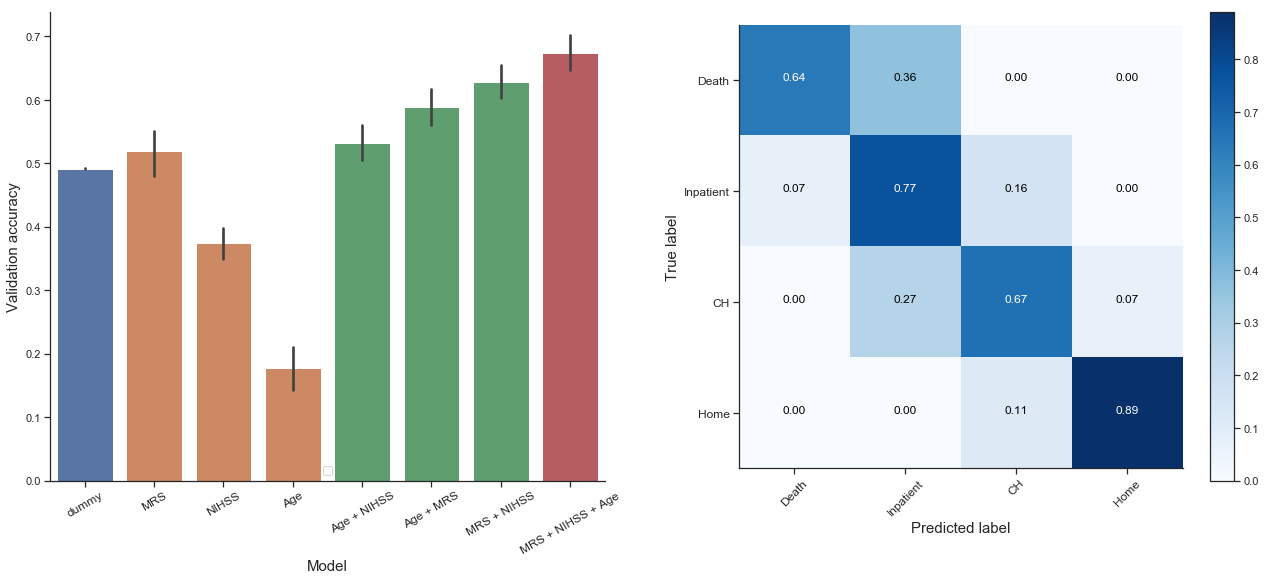

In [177]:
fig, axes = plt.subplots(ncols=2, figsize=(full_figure_width, figure_height))


flat = []
for key, value in collated_scores.items():
    for item in value:
        flat.append({key:item})
performance = pd.DataFrame.from_records(flat)
performance['model'] = performance.apply(lambda x: x.idxmax(axis=1), axis=1)
performance['test-accuracy'] = performance.apply(lambda x: x[collated_scores.keys()].max(), axis=1)
performance['number-of-variables'] = performance.model.map(model_map)
performance = performance[['model', 'test-accuracy', 'number-of-variables']]
b = sns.barplot(x='model', y='test-accuracy', hue='number-of-variables', data=performance, dodge=False,
               ax=axes[0])
plt.sca(axes[0])
plt.legend([],[])
plt.ylabel('Validation accuracy',fontsize=_xlabel_size)
plt.xlabel('Model', fontsize=_ylabel_size)
b.set_xticklabels(performance.model.unique(), rotation=30, fontsize=int(_xlabel_size*0.8))


X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)
print(X.shape)
best_rf.fit(X, y)

X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X_test = df_test[['NIHSS', 'Age']].values.reshape(-1,2)

X_test = (X_test - X.mean(axis=0)) / X.std(axis=0)

# have to add a zero column because there are no MRS=5 examples
X_test = np.concatenate((X_test, pd.get_dummies(df_test['MRS']).values, np.zeros((X_test.shape[0], 1))), axis=1)

y_pred = best_rf.predict(X_test)
y_test = df_test['Outcome'].map({v:k for k,v in outcome_dict.items()}).values


plt.sca(axes[1])
confusion_mtx = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_mtx, classes=outcome_dict.values(), normalize=True)
plt.title('')
plt.tight_layout(pad=0.4, w_pad=4, h_pad=1.0)

plt.show()

test_accuracy = best_rf.score(X_test, y_test)
test_accuracy = best_rf.score(X_test, y_test)

with open('figures/fig3.png', 'wb') as fileout:
     fig.savefig(fileout, bbox_inches='tight')



In [178]:
outcome_dict.values()

dict_values(['Death', 'Inpatient', 'CH', 'Home'])

In [179]:
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

results_dict = dict()
for i, outcome in outcome_dict.items():
    results_dict[outcome] = dict()
    results_dict[outcome]['precision'] = precision[i]
    results_dict[outcome]['recall'] = recall[i]
    results_dict[outcome]['f1'] = f1[i]

In [180]:
results_dict

{'Death': {'precision': 0.6363636363636364,
  'recall': 0.6363636363636364,
  'f1': 0.6363636363636364},
 'Inpatient': {'precision': 0.7818181818181819,
  'recall': 0.7678571428571429,
  'f1': 0.7747747747747747},
 'CH': {'precision': 0.6451612903225806,
  'recall': 0.6666666666666666,
  'f1': 0.6557377049180327},
 'Home': {'precision': 0.8888888888888888,
  'recall': 0.8888888888888888,
  'f1': 0.8888888888888888}}

In [181]:
sum((y_test[y_test==0]==y_pred[y_test==0]))

7

In [182]:
np.sqrt(sum(y_test==0)/np.pi)*2
np.sqrt(sum(y_test==1)/np.pi)*2
np.sqrt(sum(y_test==2)/np.pi)*2
np.sqrt(sum(y_test==3)/np.pi)*2

4.787307364817192

In [183]:
np.sqrt(sum(y_pred==3)/np.pi)*2


4.787307364817192

In [184]:
def circle(radius, centre, point):
    return (point[0]-centre[0])**2 + (point[1]-centre[1])**2 < radius 
    

In [185]:
circle(5, (0,0), (0,1))

True

In [186]:
np.random.random(5)

array([0.91047183, 0.07948849, 0.32218258, 0.16376082, 0.82910102])

In [187]:
points = 10*np.random.random(10000).reshape(-1, 2)
overlap = dict()
for offset in np.arange(0, 5, 0.01):
    inside_a = np.array([circle(2, (5, 5), point) for point in points])
    inside_b = np.array([circle(4, (5+offset, 5), point) for point in points])
    
    overlap[offset] = sum(inside_a[inside_b==True])

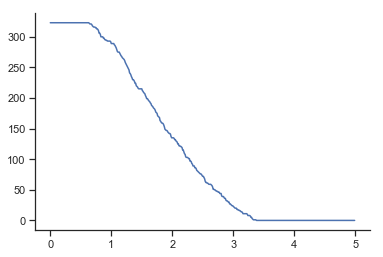

In [188]:
plt.plot(overlap.keys(), overlap.values())

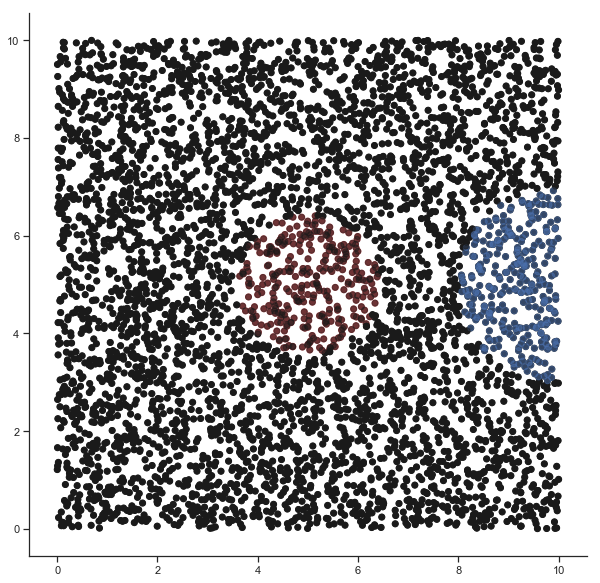

In [189]:
plt.figure(figsize=(10,10))
ax = plt.scatter(points[:,0], points[:,1], color=['r' if i else 'k' for i in inside_a])
ax = plt.scatter(points[:,0], points[:,1], color=['b' if i else 'k' for i in inside_b], alpha=.5)


### Stats on effects of multiple predictors

Effect of model, p=7.59558976416006e-15 from Kruskal Wallace


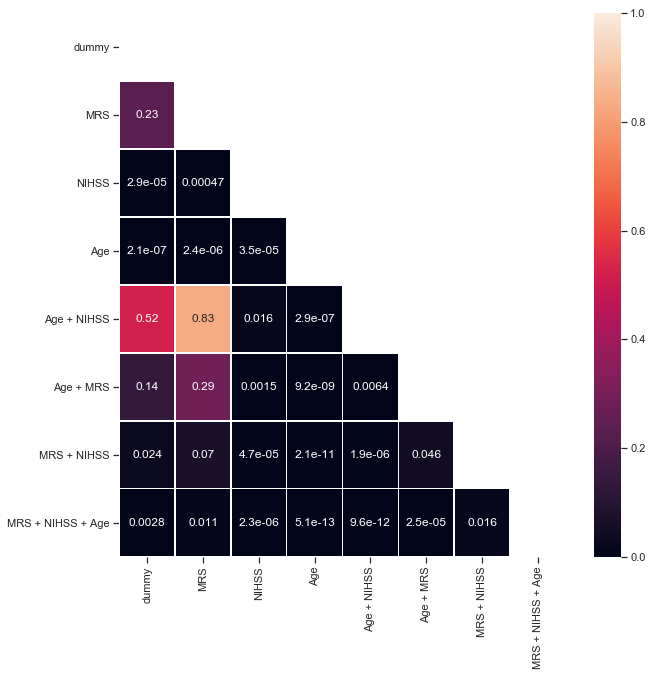

In [190]:

F, p = stats.kruskal(*collated_scores.values())

print(f"Effect of model, p={p} from Kruskal Wallace")

p_mtx = np.zeros((len(collated_scores), len(collated_scores))) 
for i, model1 in enumerate(collated_scores.keys()):
    for j, model2 in enumerate(collated_scores.keys()):
         _ , p_mtx[i, j]= stats.ttest_ind(collated_scores[model1],
           collated_scores[model2])

mask = np.zeros_like(p_mtx)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
sns.heatmap(p_mtx, xticklabels=collated_scores.keys(), yticklabels=collated_scores.keys(), mask=mask, annot=True, linewidths=.5)

plt.show()
    
    

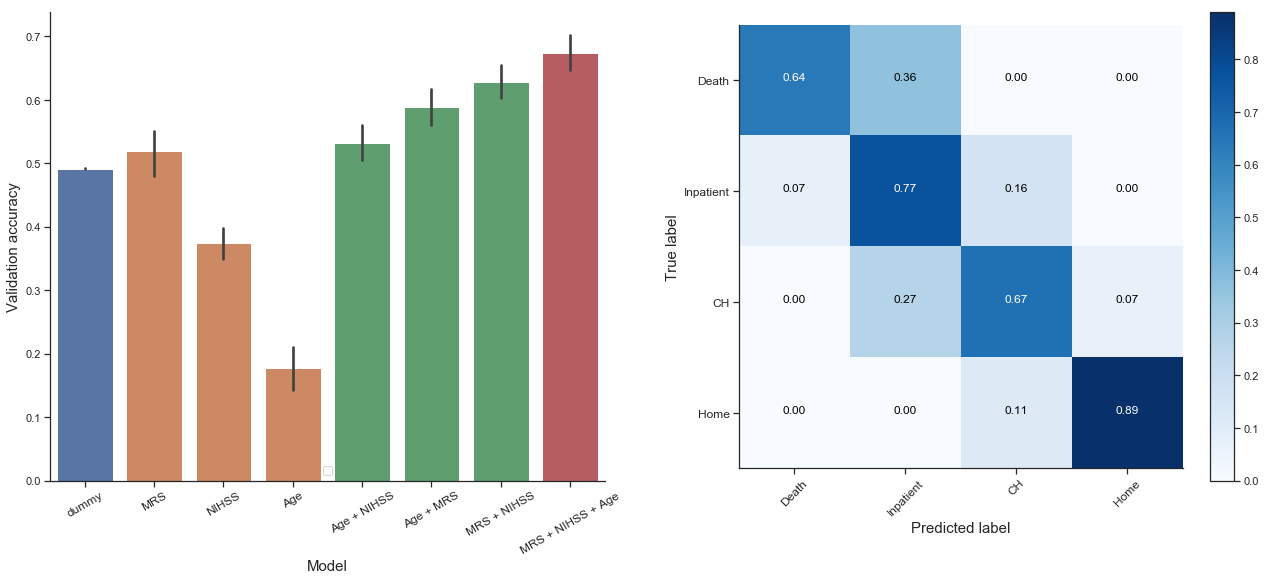

In [191]:
b.figure

In [192]:
b.

SyntaxError: invalid syntax (<ipython-input-192-fce66b6d5428>, line 1)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
%%capture
X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)

poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(X)

score_dict = {}
for c in np.linspace(0.01, 5, 15):
    lm = LogisticRegression(multi_class='multinomial', solver='saga', class_weight=None, max_iter=1000, C=c)
    scores = run_model(X, lm=lm)

    score_dict[c] = {k :np.mean(v) for k,v in scores.items()}

In [ ]:
plt.title('Logistic Regression with poly2 features')
plt.plot(score_dict.keys(), [v['test_accuracy'] for v in score_dict.values()])

In [ ]:
%%capture
X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)


score_dict = {}
for c in np.linspace(0.01, 5, 15):

    lm = LogisticRegression(multi_class='multinomial', solver='saga', class_weight=None, max_iter=1000, C=c)
    scores = run_model(X, lm=lm)

    score_dict[c] = {k :np.mean(v) for k,v in scores.items()}


In [ ]:
plt.title('Vanilla Logistic Regression')
plt.plot(score_dict.keys(), [v['test_accuracy'] for v in score_dict.values()])

## Simple model for visualization

In [ ]:
X = df_train[['NIHSS', 'Age']]

train_mean = X.mean()
train_std = X.std()
X = X.apply(lambda x: (x - train_mean)/train_std, axis=1).values.reshape(-1,2)

X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)

#poly = PolynomialFeatures(interaction_only=True)
#X = poly.fit_transform(X)

lm = LogisticRegression(multi_class='multinomial', solver='saga', fit_intercept=False)
lm.fit(X, y)

In [ ]:
params = ['NIHSS', 'Age', 'M0', 'M1', 'M2', 'M3', 'M4', 'M5']

In [ ]:
plt.figure(figsize=(15,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.bar(range(lm.coef_.shape[1]), lm.coef_[i])
    plt.ylim((-3, 3))
    plt.title(outcome_dict[i])
    plt.xticks(range(len(params)), params, rotation=40)

In [ ]:
params = np.append(lm.intercept_[-1],lm.coef_[-1])
predictions = lm.predict(X)

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
print(myDF3)

In [ ]:
from ipywidgets import interactive

def normalize(item, mean, std):
    return np.asarray((item-mean) / std).reshape(1, -1)

def one_hot_mrs(mrs):
    z = np.zeros(6)
    z[mrs] = 1
    return z

def unconditional_graphs(age, nihss, mrs, probs):
       
    plt.figure(figsize=(15,3))
    plt.subplot(141)
    sns.distplot(df['Age'],rug=True)
    plt.axvline(age, color='r')
    
    plt.subplot(142)
    sns.distplot(df['NIHSS'], rug=True)
    plt.axvline(nihss, color='r')
    
    plt.subplot(143)
    sns.distplot(df['MRS'], kde=False, bins=range(7))
    plt.axvline(mrs, color='r')
    
    plt.subplot(144)

    ax = plt.bar(np.arange(len(probs.reshape(-1,))), probs.reshape(-1,).tolist(), linewidth=.2)
    plt.xticks(np.arange(len(probs.reshape(-1,))), outcome_dict.values())
    plt.ylim([0, 1])
    plt.title('Predictions')


def plot_predictions_model_unconditional(age, nihss, mrs):
    example = np.concatenate([normalize(nihss, train_mean[0] ,train_std[0]),
              normalize(age, train_mean[1] ,train_std[1]),
              one_hot_mrs(mrs).reshape(1, -1)
              ],
             axis=1)
  
    probs = lm.predict_proba(example)
    unconditional_graphs(age, nihss, mrs, probs)

interactive_plot = interactive(plot_predictions_model, age=(0, 100, 2), nihss=(0, 35, 1), mrs=(0, 5, 1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

## Conditional version

In [ ]:
def plot_predictions_model_conditional(age, nihss, mrs):
    example = np.concatenate([normalize(nihss, train_mean[0] ,train_std[0]),
              normalize(age, train_mean[1] ,train_std[1]),
              one_hot_mrs(mrs).reshape(1, -1)
              ],
             axis=1)
  
    probs = lm.predict_proba(example)
    conditional_graphs(age, nihss, mrs, probs)
    
def conditional_graphs(age, nihss, mrs, probs):
    g = sns.FacetGrid(df, col="MRS",  hue='Outcome', legend_out=True)
    g.map(sns.scatterplot, "Age", 'NIHSS', alpha=.5)
    g.add_legend()
    
    plt.sca(g.axes[0][mrs])

    plt.axvline(age, color='r')
    plt.axhline(nihss, color='r')
    plt.show()
    
    plt.figure(figsize=(5,5))
    ax = plt.bar(np.arange(len(probs.reshape(-1,))), probs.reshape(-1,).tolist(), linewidth=.2)
    plt.xticks(np.arange(len(probs.reshape(-1,))), outcome_dict.values())
    plt.ylim([0, 1])
    plt.title('Predictions')

In [ ]:
import joblib
joblib.dump(lm, 'logistic_regression.model')


In [ ]:
type(train_mean)

In [ ]:
train_mean

In [ ]:
train_std

In [ ]:
interactive_plot = interactive(plot_predictions_model_conditional, age=(0, 100, 2), nihss=(0, 35, 1), mrs=(0, 5, 1))
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

# TO DO
- [ ] Conditional visualization
- [x] Probability density estimates for NIHSS/MRS
- [ ] MLP
- [ ] Webapp
- [ ] Random forest

In [ ]:
age = 50
nihss = 30
mrs = 3



## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
nbrs = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')

In [ ]:
run_model(X, lm=nbrs)

In [ ]:
%%capture
X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)

poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(X)

score_dict = {}
for n in np.arange(1, 30):
    nbrs = KNeighborsClassifier(n_neighbors=n, algorithm='ball_tree')
    scores = run_model(X, lm=nbrs)

    score_dict[n] = {k :np.mean(v) for k,v in scores.items()}

In [ ]:
plt.plot(score_dict.keys(), [v['test_accuracy'] for v in score_dict.values()])

In [ ]:
plt.plot(score_dict.keys(), [v['test_accuracy'] for v in score_dict.values()])

In [ ]:
np.mean(X, axis=0)

## Random forest

In [ ]:
%%capture
from sklearn.ensemble import RandomForestClassifier
max_d= 12
max_s = 8

X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)

acc = np.zeros((max_d, max_s))

for d in range(5, max_d):
    for s in range(2, max_s):
        rf = RandomForestClassifier(n_estimators=100, max_depth=d, min_samples_split=s)
        scores = run_model(X, rf=rf)
        score_dict[d,s] = {k :np.mean(v) for k,v in scores.items()}
        acc[d, s] = score_dict[d,s]['test_accuracy']

In [ ]:
sns.heatmap(acc, annot=True, mask=acc==0, fmt='.3g')

In [ ]:
X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)

best_rf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=3)
scores = run_model(X, rf=best_rf)
score_dict[d,s] = {k :np.mean(v) for k,v in scores.items()}
print(score_dict[d,s]['test_accuracy'])

best_rf.fit(X, y)

### Use MRS as a continuous input

In [ ]:
%%capture
from sklearn.ensemble import RandomForestClassifier
max_d= 20
max_s = 20

X = df_train[['NIHSS', 'Age', 'MRS']].values.reshape(-1,3)
X = stats.zscore(X)

acc = np.zeros((max_d, max_s))

for d in range(2, max_d):
    for s in range(2, max_s):
        rf = RandomForestClassifier(n_estimators=100, max_depth=d, min_samples_split=s)
        scores = run_model(X, rf=rf)
        score_dict[d,s] = {k :np.mean(v) for k,v in scores.items()}
        acc[d, s] = score_dict[d,s]['test_accuracy']

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(acc, annot=True, mask=acc==0, fmt='0.3g', ax=ax, linewidths=2, vmin=0.5, vmax=0.8)

## Gradient Boosted

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
%%capture
max_d= 6
max_s = 6
acc = np.zeros((max_d, max_s))

for d in range(3, max_d):
    for s in range(3, max_s):
        rf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=d, min_samples_split=s)
        scores = run_model(X, lm=rf)
        score_dict[d,s] = {k :np.mean(v) for k,v in scores.items()}
        acc[d, s] = score_dict[d,s]['test_accuracy']

In [ ]:
sns.heatmap(acc, annot=True, mask=acc==0, fmt='.3g')

# Modelling summary
- Logistic regression gives you about 0.68
- Nearest neighbour roughly the same, a fraction worse
- Adding polynomial features gives you 0.69
- Random forest gets you to about 0.70

## Explaining the model
- [ ] Permutation importances
- [ ] Partial dependence plots
- [ ] Sample decision trees
- [ ] Per-example explanation

Working with the random forest model:

### 1. Permutation importances

In [ ]:
feature_names = ['NIHSS', 'Age', 'MRS0','MRS1','MRS2','MRS3','MRS4','MRS5']

In [ ]:
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(best_rf).fit(X, y)
eli5.explain_weights(perm, target_names=outcome_dict, feature_names=feature_names, targets=outcome_dict.keys())

In [ ]:
from eli5 import explain_weights
from eli5 import formatters
obj = explain_weights(best_rf, feature_names=feature_names)
expl_df = formatters.format_as_dataframe(obj)

In [ ]:
expl_df

In [ ]:
expl_df.iloc[2:]['weight'].sum()

In [ ]:
df_train.iloc[3]

In [ ]:
X[3,:]

In [ ]:
best_rf.predict_proba(X[3,:].reshape(1, -1))

In [ ]:
def plot_explanation_for_prediction(model, x, feature_names=feature_names, ax=None):
    explanation = explain_prediction(best_rf, x,feature_names=feature_names)
    expl = formatters.as_dataframe.format_as_dataframe(explanation)

    expl = expl.sort_values('feature')
    expl.rename({'feature':'Feature', 'weight':'Weight', 'outcome':'Outcome'}, inplace=True, axis=1)

    expl['Outcome'] = expl['target'].map(outcome_dict)
    expl['include'] = expl['value'] != 0
    
    g = sns.catplot(x="Feature", y="Weight", hue="Outcome", data=expl.loc[expl.include & (expl.Feature.str.contains('<BIAS>') == False)],
                height=6, kind="bar", ax=ax, hue_order=order)


In [ ]:
X[3,:]

In [ ]:
explanation = explain_prediction(best_rf, X[3,:],feature_names=feature_names)
expl = formatters.as_dataframe.format_as_dataframe(explanation)
expl

In [ ]:
def plot_prediction(model, x_input, ax=None):
    _pred = model.predict_proba(x_input.reshape(1, -1))
    df_prediction = pd.DataFrame(_pred.T*100, index=pd.Index(outcome_dict.values()), columns=['Probability'])
    df_prediction['Outcome']= df_prediction.index
    sns.catplot(data=df_prediction, x='Outcome', y='Probability', order=order, kind='bar', ax=ax)

In [ ]:
plot_prediction(best_rf, X[3,:])

In [ ]:
sns.set_style(_plot_style)
fig, axes = plt.subplots(ncols=3, figsize=(full_figure_width, figure_height))
plt.sca(axes[0])
plt.bar(range(len(expl_df)), expl_df['weight'].values)
plt.errorbar(range(len(expl_df)), expl_df['weight'].values, expl_df['std'].values,  fmt=' ', color='k')
plt.xticks(range(len(expl_df)), expl_df.feature)
plt.xlabel('Feature', fontsize=_xlabel_size)
plt.ylabel('Feature Importance', fontsize=_ylabel_size)
plt.tick_params(axis='both', which='major', labelsize=10)


plot_prediction(best_rf, X[3,:], ax=axes[1])
plt.sca(axes[1])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Outcome', fontsize=_xlabel_size)
plt.ylabel('% Probability', fontsize=_ylabel_size)

plot_explanation_for_prediction(best_rf, X[3,:], ax=axes[-1])
plt.sca(axes[-1])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Feature', fontsize=_xlabel_size)
plt.ylabel('Weight', fontsize=_ylabel_size)

plt.setp(axes[2].get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(axes[2].get_legend().get_title(), fontsize='0') # for legend title

sns.despine()

plt.show()

with open('figures/fig5.png', 'wb') as fileout:
    fig.savefig(fileout, bbox_inches='tight')



    

### 2. Partial Dependence Plots

Difficult to achieve this for the case of 3 dimensions with 4 output classes. I think a 3 x 4 subplot may be necessary?

In [ ]:
x_min = X.min(axis=0)
x_max = X.max(axis=0)

In [ ]:
all_probabilities = np.zeros((10,10,6,4))

In [ ]:
for i_n, _nihss in enumerate(np.linspace(x_min[0], x_max[0], 10)):
    for i_a, _age in enumerate(np.linspace(x_min[1], x_max[1], 10)):
        for _mrs in range(0, 6):
            mrs_dummies = np.zeros((6))
            mrs_dummies[_mrs] = 1
            
            input = np.concatenate((np.array([_nihss, _age]).reshape(1,-1), mrs_dummies.reshape(1,-1)), axis=1)
            prediction = best_rf.predict_proba(input)
            
            all_probabilities[i_n, i_a, _mrs, :] = prediction

In [ ]:
g = sns.FacetGrid(df, row="MRS", col="Outcome", margin_titles=True, height=1.5)

for _outcome in range(0,4):
    for _mrs in range(0, 6):
        plt.sca(g.axes[_mrs, _outcome])
        sns.heatmap(all_probabilities[:,:,_mrs,_outcome], cbar=False, vmin=0, vmax=1, cmap="Blues")
        sns.despine()
        
for i in range(0,4):
    g.axes[-1,i].set_xlabel(outcome_dict[i] + '\n Age')

for i in range(0,6):
    g.axes[i,0].set_ylabel("MRS-%d \n NIHSS Score"%i)

g.fig.subplots_adjust(wspace=.05, hspace=.05)

### 4. Per-prediction explanation

In [ ]:
from eli5 import show_prediction, explain_prediction
show_prediction(best_rf, X[0,:],show_feature_values=True, feature_names=feature_names)

In [ ]:
plot_explanation_for_prediction(best_rf, X[2,:])